The general idea behind this notebook is to show how we can use NMF to get a meaningful representation of images. We'll be working with the [Random Sample of NIH Chest X-ray Dataset](https://www.kaggle.com/datasets/nih-chest-xrays/sample), which a 5% sample of the [NIH Chest X-rays](https://www.kaggle.com/datasets/nih-chest-xrays/data?resource=download) dataset. The random sample contains 5606 X-ray images and class labels.

In [36]:
from skimage import io, transform
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

BASE_PATH = '../data/nih/images/'
SEED = 101

In [2]:
df = pd.read_csv('../data/nih/sample_labels.csv')
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [37]:
def load_image(fname, output_shape=(256, 256)):
    img = io.imread(fname)
    if len(img.shape)>2:
        img = img[:,:,0]
    img = transform.resize(img, output_shape=output_shape)
    return img

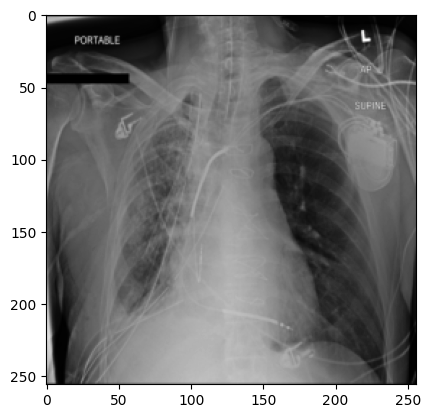

In [38]:
fname = '../data/nih/images/00000013_005.png'
img = load_image(fname)
plt.imshow(img, cmap='gray')

In [6]:
fnames = [BASE_PATH + fname for fname in df['Image Index'].tolist()]
df['img_size'] = [io.imread(fname).size for fname in tqdm(fnames)]
df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 5606/5606 [01:22<00:00, 68.23it/s]


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,img_size
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,1048576
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,1048576
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,1048576
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,1048576
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,1048576


In [9]:
df['img_size'].value_counts()

1048576    5583
Name: img_size, dtype: int64

Drop any rows that are not 1024 by 1024. We probably could handle these, but we have enough images to avoid using them.

In [8]:
idx_keep = df['img_size'] == 1048576
df = df[idx_keep]

Now we can construct a dataset and train an NMF model. For purposes of this tutorial, I am going to resize the images to 256 by 256, which should speed things up substantially. Note that the ability to train an NMF model has been around for a while, so let's start by training a standard NMF model with 20 components. We'll also normalize each image to account for differences in brightness/contrast.

In [40]:
fnames = [BASE_PATH + fname for fname in df['Image Index'].tolist()]
# imgs = np.array([transform.resize(io.imread(fname), output_shape=(256, 256)) for fname in tqdm(fnames)])
imgs = np.array([load_image(fname) for fname in tqdm(fnames)])
imgs.shape


  3%|██▋                                                                            | 195/5606 [00:07<03:27, 26.07it/s]


  7%|█████▌                                                                         | 393/5606 [00:14<03:19, 26.12it/s]


 11%|████████▎                                                                      | 591/5606 [00:22<03:02, 27.52it/s]


 14%|███████████                                                                    | 789/5606 [00:29<02:57, 27.21it/s]


 18%|█████████████▉                                                                 | 987/5606 [00:36<02:48, 27.35it/s]


 21%|████████████████▍                                                             | 1185/5606 [00:43<02:49, 26.02it/s]


 25%|███████████████████▏                                                          | 1383/5606 [00:50<02:26, 28.73it/s]


 28%|█████████████████████▉                                                        | 1581/5606 [00:58<02:28, 27.04it/s]


 32%|████████████████████████▊                                                     | 1779/5606 [01:06<02:40, 23.89it/s]


 35%|███████████████████████████▌                                                  | 1977/5606 [01:14<02:19, 26.10it/s]


 39%|██████████████████████████████▎                                               | 2175/5606 [01:21<02:05, 27.42it/s]


 42%|█████████████████████████████████                                             | 2374/5606 [01:29<01:58, 27.23it/s]


 46%|███████████████████████████████████▊                                          | 2572/5606 [01:36<01:44, 28.95it/s]


 49%|██████████████████████████████████████▌                                       | 2770/5606 [01:44<01:56, 24.31it/s]


 53%|█████████████████████████████████████████▎                                    | 2968/5606 [01:51<01:34, 27.78it/s]


 56%|████████████████████████████████████████████                                  | 3166/5606 [01:59<01:53, 21.48it/s]


 60%|██████████████████████████████████████████████▊                               | 3364/5606 [02:07<01:24, 26.66it/s]


 64%|█████████████████████████████████████████████████▌                            | 3562/5606 [02:14<01:12, 28.06it/s]


 67%|████████████████████████████████████████████████████▎                         | 3761/5606 [02:22<01:05, 28.00it/s]


 71%|███████████████████████████████████████████████████████                       | 3959/5606 [02:29<01:02, 26.30it/s]


 74%|█████████████████████████████████████████████████████████▊                    | 4157/5606 [02:37<00:57, 25.32it/s]


 78%|████████████████████████████████████████████████████████████▌                 | 4355/5606 [02:44<00:47, 26.51it/s]


 81%|███████████████████████████████████████████████████████████████▎              | 4553/5606 [02:52<00:41, 25.39it/s]


 85%|██████████████████████████████████████████████████████████████████            | 4751/5606 [02:59<00:30, 27.59it/s]


 88%|████████████████████████████████████████████████████████████████████▊         | 4949/5606 [03:08<00:31, 21.16it/s]


 92%|███████████████████████████████████████████████████████████████████████▋      | 5148/5606 [03:16<00:18, 25.43it/s]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5346/5606 [03:23<00:09, 27.11it/s]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5547/5606 [03:31<00:02, 26.72it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 5606/5606 [03:33<00:00, 26.22it/s]


(5606, 256, 256)

In [41]:
imgs_flat = imgs.reshape(imgs.shape[0], imgs.shape[1]*imgs.shape[2])
imgs_flat.shape

(5606, 65536)

In [42]:
from sklearn.decomposition import NMF, MiniBatchNMF
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline

nmf = NMF(
    n_components=20,
    init='nndsvda',
    solver='mu',
    beta_loss='frobenius',
    max_iter=1000,
    random_state=SEED,
    verbose=True
)

nmf_pipe = Pipeline(
    [
        ('norm', Normalizer(norm='l2')),
        ('nmf', nmf)
    ]
)
nmf_pipe.fit(imgs_flat)

Epoch 10 reached after 9.954 seconds, error: 17.485860
Epoch 20 reached after 17.210 seconds, error: 16.210175
Epoch 30 reached after 24.019 seconds, error: 15.414482
Epoch 40 reached after 30.881 seconds, error: 14.878002
Epoch 50 reached after 37.937 seconds, error: 14.503376
Epoch 60 reached after 44.711 seconds, error: 14.231798
Epoch 70 reached after 51.481 seconds, error: 14.027530
Epoch 80 reached after 58.327 seconds, error: 13.868550
Epoch 90 reached after 65.070 seconds, error: 13.741435
Epoch 100 reached after 71.753 seconds, error: 13.637612
Epoch 110 reached after 78.430 seconds, error: 13.551133
Epoch 120 reached after 85.234 seconds, error: 13.477804
Epoch 130 reached after 92.237 seconds, error: 13.414649
Epoch 140 reached after 99.275 seconds, error: 13.359474
Epoch 150 reached after 106.155 seconds, error: 13.310673
Epoch 160 reached after 113.132 seconds, error: 13.267056
Epoch 170 reached after 120.171 seconds, error: 13.227702
Epoch 180 reached after 127.256 second

Pipeline(steps=[('norm', Normalizer()),
                ('nmf',
                 NMF(init='nndsvda', max_iter=1000, n_components=20,
                     random_state=101, solver='mu', verbose=True))])

Just so we don't end up having to re-do this live, I am persisting the trained pipeline to a joblib file.

In [31]:
import joblib

joblib.dump(nmf_pipe, '../output/nmf_pipe.joblib')

['../output/nmf_pipe.joblib']

As a callback to the earlier notebook, we can actually get feature names from this transformer. Of course, we aren't propagating labels from the raw pixel values, so the features don't exactly have meaningful names.

In [43]:
features = nmf_pipe['nmf'].get_feature_names_out()
features

array(['nmf0', 'nmf1', 'nmf2', 'nmf3', 'nmf4', 'nmf5', 'nmf6', 'nmf7',
       'nmf8', 'nmf9', 'nmf10', 'nmf11', 'nmf12', 'nmf13', 'nmf14',
       'nmf15', 'nmf16', 'nmf17', 'nmf18', 'nmf19'], dtype=object)

Given that this process essentially gives us a new basis, let's plot those representations and see what they look like.

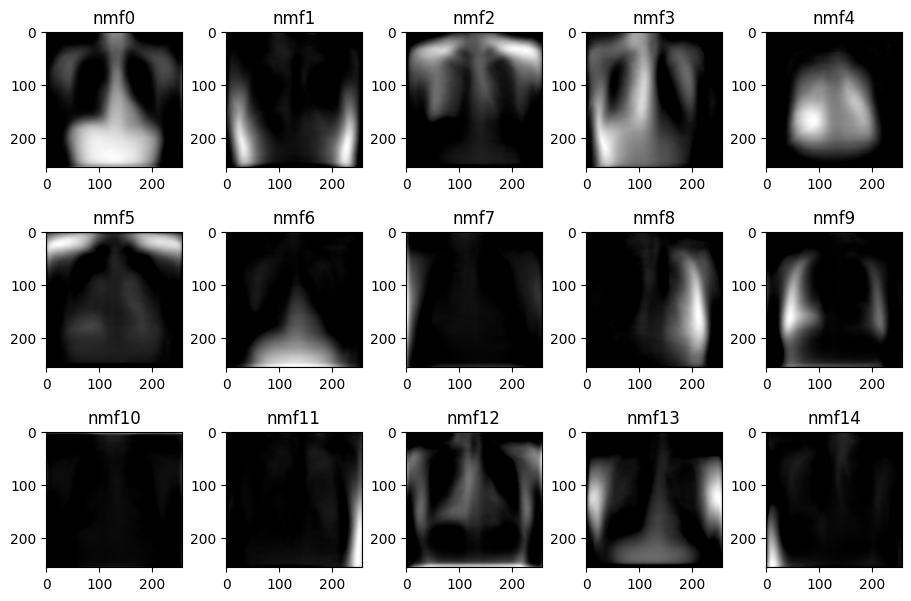

In [59]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(9,6), constrained_layout=True)
# for j, i in enumerate([1, 2, 3, 5, 7, 11]):
for i in range(15):
    ax.flat[i].set_title(features[i], fontsize=12)
    ax.flat[i].imshow(nmf_pipe['nmf'].components_[i].reshape(256, 256), cmap='gray')
plt.show()

We can directly compare inputs and outputs. Transform an image into NMF components, then add them back together and see how close it is.

In [51]:
i = 23
X = nmf_pipe['nmf'].transform([imgs_flat[i]])
img_in = nmf_pipe['norm'].transform([imgs_flat[i]]).reshape(256, 256)
img_out = nmf_pipe['nmf'].inverse_transform(X).reshape(256, 256)

Epoch 10 reached after 0.001 seconds, error: 29.349501
Epoch 20 reached after 0.002 seconds, error: 27.603448
Epoch 30 reached after 0.002 seconds, error: 26.861831
Epoch 40 reached after 0.002 seconds, error: 26.476355
Epoch 50 reached after 0.003 seconds, error: 26.249422
Epoch 60 reached after 0.003 seconds, error: 26.104814
Epoch 70 reached after 0.003 seconds, error: 26.007199
Epoch 80 reached after 0.003 seconds, error: 25.938290
Epoch 90 reached after 0.003 seconds, error: 25.887889
Epoch 100 reached after 0.003 seconds, error: 25.849966
Epoch 110 reached after 0.004 seconds, error: 25.820775
Epoch 120 reached after 0.004 seconds, error: 25.797884
Epoch 130 reached after 0.004 seconds, error: 25.779652
Epoch 140 reached after 0.005 seconds, error: 25.764938
Epoch 150 reached after 0.005 seconds, error: 25.752926


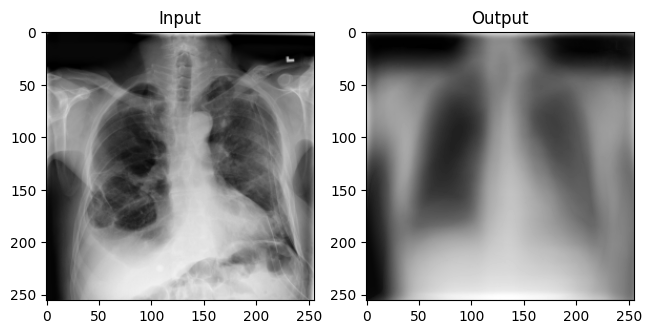

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
ax[0].set_title('Input')
ax[0].imshow(img_in, cmap='gray')
ax[1].set_title('Output')
ax[1].imshow(img_out, cmap='gray')
plt.show()

So as we can see, we have a model that does _all right_ for reconstructing the input image. It's worth noting that it took a decent amount of time to train the NMF transformer (~10 minutes), and this was for a relatively small number of topics. Furthermore, this only works for data that can fit in memory. Let's experiment with the MiniBatchNMF transformer.

In [47]:
from sklearn.decomposition import NMF, MiniBatchNMF
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline

minibatch_nmf = MiniBatchNMF(
    n_components=20,
    batch_size=len(imgs_flat),
    init='nndsvda', # Is slow to start because it has to compute the mean across all images? No, doesn't seem to be the case. This is an issue w/ the number of samples and the dimensionality.
    beta_loss='frobenius',
    max_iter=1000,
    random_state=SEED,
    max_no_improvement=20,
    verbose=True
)

minibatch_nmf_pipe = Pipeline(
    [
        ('norm', Normalizer(norm='l2')),
        ('nmf', minibatch_nmf)
    ]
)
minibatch_nmf_pipe.fit(imgs_flat)

Minibatch step 1/1000: mean batch cost: 0.04414812963179041
Minibatch step 2/1000: mean batch cost: 0.03850031111803865, ewa cost: 0.03850031111803865
Minibatch step 3/1000: mean batch cost: 0.03685481703701259, ewa cost: 0.036855111717184696
Minibatch step 4/1000: mean batch cost: 0.035717743912829156, ewa cost: 0.035717947596175206
Minibatch step 5/1000: mean batch cost: 0.034773244640363514, ewa cost: 0.03477341382069228
Minibatch step 6/1000: mean batch cost: 0.03394674027050028, ewa cost: 0.033946888313757834
Minibatch step 7/1000: mean batch cost: 0.03321006695410092, ewa cost: 0.033210198906350144
Minibatch step 8/1000: mean batch cost: 0.03254727475694895, ewa cost: 0.03254739347545708
Minibatch step 9/1000: mean batch cost: 0.031946827840602494, ewa cost: 0.03194693539175487
Minibatch step 10/1000: mean batch cost: 0.03139957903168899, ewa cost: 0.031399677053959775
Minibatch step 11/1000: mean batch cost: 0.03089801952375638, ewa cost: 0.030898109362139298
Minibatch step 12/1

Minibatch step 90/1000: mean batch cost: 0.019356548255507512, ewa cost: 0.0193565573906259
Minibatch step 91/1000: mean batch cost: 0.019306449406754748, ewa cost: 0.019306458380247565
Minibatch step 92/1000: mean batch cost: 0.019257230933087392, ewa cost: 0.019257239748890966
Minibatch step 93/1000: mean batch cost: 0.01920887155822319, ewa cost: 0.019208880220148453
Minibatch step 94/1000: mean batch cost: 0.019161350679130103, ewa cost: 0.01916135919086739
Minibatch step 95/1000: mean batch cost: 0.0191146483360539, ewa cost: 0.01911465670117833
Minibatch step 96/1000: mean batch cost: 0.01906874518024694, ewa cost: 0.019068753402224185
Minibatch step 97/1000: mean batch cost: 0.019023622440541715, ewa cost: 0.019023630522733995
Minibatch step 98/1000: mean batch cost: 0.018979261890166296, ewa cost: 0.018979269835838315
Minibatch step 99/1000: mean batch cost: 0.01893564581524221, ewa cost: 0.018935653627566818
Minibatch step 100/1000: mean batch cost: 0.018892756986209618, ewa c

Minibatch step 177/1000: mean batch cost: 0.016908768683470764, ewa cost: 0.016908771503290593
Minibatch step 178/1000: mean batch cost: 0.016893180264173878, ewa cost: 0.016893183056301227
Minibatch step 179/1000: mean batch cost: 0.0168777437503023, ewa cost: 0.016877746515220997
Minibatch step 180/1000: mean batch cost: 0.016862456498880664, ewa cost: 0.016862459237064108
Minibatch step 181/1000: mean batch cost: 0.01684731592790133, ewa cost: 0.016847318639811995
Minibatch step 182/1000: mean batch cost: 0.01683231951879551, ewa cost: 0.016832322204884516
Minibatch step 183/1000: mean batch cost: 0.016817464818503828, ewa cost: 0.016817467479210556
Minibatch step 184/1000: mean batch cost: 0.016802749441060336, ewa cost: 0.016802752076812155
Minibatch step 185/1000: mean batch cost: 0.01678817106865857, ewa cost: 0.016788173679870632
Minibatch step 186/1000: mean batch cost: 0.01677372745222448, ewa cost: 0.01677373003929963
Minibatch step 187/1000: mean batch cost: 0.0167594164115

Minibatch step 265/1000: mean batch cost: 0.015942294131386252, ewa cost: 0.015942295510030235
Minibatch step 266/1000: mean batch cost: 0.015934649803137864, ewa cost: 0.015934651172354715
Minibatch step 267/1000: mean batch cost: 0.0159270575942144, ewa cost: 0.015927058954095873
Minibatch step 268/1000: mean batch cost: 0.015919516988297952, ewa cost: 0.015919518338936525
Minibatch step 269/1000: mean batch cost: 0.015912027462690635, ewa cost: 0.015912028804179933
Minibatch step 270/1000: mean batch cost: 0.015904588486981324, ewa cost: 0.01590458981941635
Minibatch step 271/1000: mean batch cost: 0.015897199522810778, ewa cost: 0.015897200846287967
Minibatch step 272/1000: mean batch cost: 0.01588986002474143, ewa cost: 0.01588986133935847
Minibatch step 273/1000: mean batch cost: 0.015882569442138943, ewa cost: 0.015882570747994464
Minibatch step 274/1000: mean batch cost: 0.0158753272218932, ewa cost: 0.01587532851908627
Minibatch step 275/1000: mean batch cost: 0.01586813281173

Minibatch step 352/1000: mean batch cost: 0.015427137866895708, ewa cost: 0.015427138685950517
Minibatch step 353/1000: mean batch cost: 0.01542258994838059, ewa cost: 0.01542259076298259
Minibatch step 354/1000: mean batch cost: 0.01541806660208768, ewa cost: 0.015418067412288412
Minibatch step 355/1000: mean batch cost: 0.015413567520375508, ewa cost: 0.015413568326230077
Minibatch step 356/1000: mean batch cost: 0.015409092377365097, ewa cost: 0.015409093178931871
Minibatch step 357/1000: mean batch cost: 0.01540464083121961, ewa cost: 0.015404641628559815
Minibatch step 358/1000: mean batch cost: 0.015400212527112534, ewa cost: 0.015400213320289726
Minibatch step 359/1000: mean batch cost: 0.015395807100962883, ewa cost: 0.015395807890042275
Minibatch step 360/1000: mean batch cost: 0.015391424184032622, ewa cost: 0.01539142496908026
Minibatch step 361/1000: mean batch cost: 0.015387063408471206, ewa cost: 0.015387064189552976
Minibatch step 362/1000: mean batch cost: 0.01538272441

Minibatch step 439/1000: mean batch cost: 0.015105812866776583, ewa cost: 0.015105813402808215
Minibatch step 440/1000: mean batch cost: 0.015102833436300036, ewa cost: 0.01510283396996166
Minibatch step 441/1000: mean batch cost: 0.015099867366775016, ewa cost: 0.015099867898043495
Minibatch step 442/1000: mean batch cost: 0.015096914788486335, ewa cost: 0.015096915317338332
Minibatch step 443/1000: mean batch cost: 0.015093975826156356, ewa cost: 0.015093976352569535
Minibatch step 444/1000: mean batch cost: 0.015091050593149132, ewa cost: 0.015091051117103182
Minibatch step 445/1000: mean batch cost: 0.015088139186761069, ewa cost: 0.015088139708238565
Minibatch step 446/1000: mean batch cost: 0.015085241684665749, ewa cost: 0.015085242203652777
Minibatch step 447/1000: mean batch cost: 0.01508235814244904, ewa cost: 0.015082358658935644
Minibatch step 448/1000: mean batch cost: 0.015079488592081584, ewa cost: 0.015079489106062037
Minibatch step 449/1000: mean batch cost: 0.01507663

Minibatch step 526/1000: mean batch cost: 0.014890571989006509, ewa cost: 0.01489057235847935
Minibatch step 527/1000: mean batch cost: 0.014888516976368456, ewa cost: 0.014888517344452644
Minibatch step 528/1000: mean batch cost: 0.014886469647537781, ewa cost: 0.014886470014245682
Minibatch step 529/1000: mean batch cost: 0.014884429929967266, ewa cost: 0.014884430295311871
Minibatch step 530/1000: mean batch cost: 0.014882397748258431, ewa cost: 0.014882398112253246
Minibatch step 531/1000: mean batch cost: 0.014880373024971815, ewa cost: 0.014880373387630711
Minibatch step 532/1000: mean batch cost: 0.01487835568152313, ewa cost: 0.014878356042860185
Minibatch step 533/1000: mean batch cost: 0.014876345639102414, ewa cost: 0.01487634599913174
Minibatch step 534/1000: mean batch cost: 0.014874342819556463, ewa cost: 0.01487434317829206
Minibatch step 535/1000: mean batch cost: 0.014872347146178078, ewa cost: 0.014872347503633686
Minibatch step 536/1000: mean batch cost: 0.0148703585

Minibatch step 613/1000: mean batch cost: 0.014734359925487531, ewa cost: 0.014734360209139766
Minibatch step 614/1000: mean batch cost: 0.014732780761192547, ewa cost: 0.014732781044044973
Minibatch step 615/1000: mean batch cost: 0.014731206260932134, ewa cost: 0.014731206542949167
Minibatch step 616/1000: mean batch cost: 0.014729636688256656, ewa cost: 0.014729636969391093
Minibatch step 617/1000: mean batch cost: 0.014728072360236643, ewa cost: 0.014728072640431692
Minibatch step 618/1000: mean batch cost: 0.014726513625588635, ewa cost: 0.014726513904781838
Minibatch step 619/1000: mean batch cost: 0.014724960834306772, ewa cost: 0.014724961112435438
Minibatch step 620/1000: mean batch cost: 0.014723414303469061, ewa cost: 0.014723414580476397
Minibatch step 621/1000: mean batch cost: 0.014721874285568929, ewa cost: 0.014721874561409706
Minibatch step 622/1000: mean batch cost: 0.014720340945624038, ewa cost: 0.014720341220268699
Minibatch step 623/1000: mean batch cost: 0.014718

Minibatch step 700/1000: mean batch cost: 0.014615410620130503, ewa cost: 0.014615410834766498
Minibatch step 701/1000: mean batch cost: 0.014614216095422456, ewa cost: 0.014614216309380075
Minibatch step 702/1000: mean batch cost: 0.014613025295829868, ewa cost: 0.01461302550912026
Minibatch step 703/1000: mean batch cost: 0.014611838157482583, ewa cost: 0.014611838370117189
Minibatch step 704/1000: mean batch cost: 0.014610654615718281, ewa cost: 0.014610654827708682
Minibatch step 705/1000: mean batch cost: 0.014609474605704224, ewa cost: 0.014609474817062033
Minibatch step 706/1000: mean batch cost: 0.014608298062859043, ewa cost: 0.014608298273595827
Minibatch step 707/1000: mean batch cost: 0.014607124923100413, ewa cost: 0.014607125133227651
Minibatch step 708/1000: mean batch cost: 0.014605955122941959, ewa cost: 0.014605955332471022
Minibatch step 709/1000: mean batch cost: 0.014604788599466465, ewa cost: 0.014604788808408622
Minibatch step 710/1000: mean batch cost: 0.0146036

Minibatch step 787/1000: mean batch cost: 0.014521892118308987, ewa cost: 0.014521892287290082
Minibatch step 788/1000: mean batch cost: 0.014520951380304759, ewa cost: 0.014520951548805294
Minibatch step 789/1000: mean batch cost: 0.014520013291485181, ewa cost: 0.014520013459511207
Minibatch step 790/1000: mean batch cost: 0.014519077822905528, ewa cost: 0.014519077990462226
Minibatch step 791/1000: mean batch cost: 0.014518144950325407, ewa cost: 0.01451814511741712
Minibatch step 792/1000: mean batch cost: 0.014517214654045003, ewa cost: 0.014517214820675263
Minibatch step 793/1000: mean batch cost: 0.014516286918735983, ewa cost: 0.014516287084907533
Minibatch step 794/1000: mean batch cost: 0.014515361733284106, ewa cost: 0.014515361898998939
Minibatch step 795/1000: mean batch cost: 0.014514439090647533, ewa cost: 0.014514439255906909
Minibatch step 796/1000: mean batch cost: 0.014513518987716127, ewa cost: 0.014513519152520603
Minibatch step 797/1000: mean batch cost: 0.0145126

Minibatch step 874/1000: mean batch cost: 0.014448163796049646, ewa cost: 0.014448163934569477
Minibatch step 875/1000: mean batch cost: 0.014447392065137309, ewa cost: 0.014447392203366074
Minibatch step 876/1000: mean batch cost: 0.014446621971751802, ewa cost: 0.014446622109687264
Minibatch step 877/1000: mean batch cost: 0.014445853527671845, ewa cost: 0.014445853665311892
Minibatch step 878/1000: mean batch cost: 0.014445086743837324, ewa cost: 0.014445086881179996
Minibatch step 879/1000: mean batch cost: 0.01444432163023164, ewa cost: 0.01444432176727515
Minibatch step 880/1000: mean batch cost: 0.014443558195738728, ewa cost: 0.014443558332481482
Minibatch step 881/1000: mean batch cost: 0.01444279644797477, ewa cost: 0.014442796584415404
Minibatch step 882/1000: mean batch cost: 0.014442036393098372, ewa cost: 0.014442036529235786
Minibatch step 883/1000: mean batch cost: 0.014441278035603742, ewa cost: 0.014441278171437128
Minibatch step 884/1000: mean batch cost: 0.014440521

Minibatch step 961/1000: mean batch cost: 0.014386518603125276, ewa cost: 0.014386518720189999
Minibatch step 962/1000: mean batch cost: 0.014385866145590882, ewa cost: 0.01438586626245596
Minibatch step 963/1000: mean batch cost: 0.014385214791692217, ewa cost: 0.014385214908359617
Minibatch step 964/1000: mean batch cost: 0.014384564531321515, ewa cost: 0.014384564647793049
Minibatch step 965/1000: mean batch cost: 0.014383915355220786, ewa cost: 0.014383915471498109
Minibatch step 966/1000: mean batch cost: 0.014383267254916518, ewa cost: 0.01438326737100115
Minibatch step 967/1000: mean batch cost: 0.014382620222619956, ewa cost: 0.01438262033851329
Minibatch step 968/1000: mean batch cost: 0.014381974251104265, ewa cost: 0.014381974366807597
Minibatch step 969/1000: mean batch cost: 0.014381329333570907, ewa cost: 0.014381329449085456
Minibatch step 970/1000: mean batch cost: 0.014380685463517512, ewa cost: 0.014380685578844438
Minibatch step 971/1000: mean batch cost: 0.014380042

C:\Users\jking\Miniconda3\envs\sklearn1dot2\lib\site-packages\sklearn\decomposition\_nmf.py:2239: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Pipeline(steps=[('norm', Normalizer()),
                ('nmf',
                 MiniBatchNMF(batch_size=5583, init='nndsvda', max_iter=1000,
                              max_no_improvement=20, n_components=20,
                              random_state=101, verbose=True))])

In [48]:
import joblib

joblib.dump(minibatch_nmf_pipe, '../output/minibatch_nmf_pipe.joblib')

['../output/minibatch_nmf_pipe.joblib']

In [49]:
i = 13
X = minibatch_nmf_pipe['nmf'].transform([imgs_flat[i]])
img_in = minibatch_nmf_pipe['norm'].transform([imgs_flat[i]]).reshape(256, 256)
img_out = minibatch_nmf_pipe['nmf'].inverse_transform(X).reshape(256, 256)

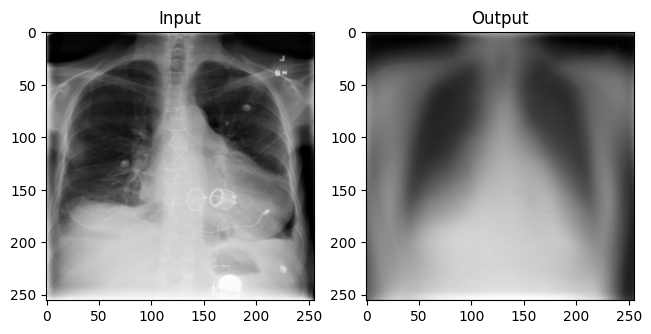

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
ax[0].set_title('Input')
ax[0].imshow(img_in, cmap='gray')
ax[1].set_title('Output')
ax[1].imshow(img_out, cmap='gray')
plt.show()

In [51]:
nmf_pipe['nmf'].reconstruction_err_

12.574525795004806

In [52]:
minibatch_nmf_pipe['nmf'].reconstruction_err_

12.663362192958802